In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Funciones de Yellow Brick
from yellowbrick.classifier import (
    ConfusionMatrix
)

from yellowbrick.model_selection import (
    ValidationCurve, 
)

sns.set_palette("colorblind")
SEED = 42

In [22]:
# Importing data
engine_ds= pd.read_csv("../data/interim/engine_data_w_efficiency_downsampled.csv")

# sns.barplot(
#     data = (engine_ds
#             .groupby(['Engine Condition'])
#             .size()
#             .reset_index(name = 'n_engine')),
#     x = 'Engine Condition',
#     y = 'n_engine'
# )
# plt.title("Engine condition distribution")
# plt.show()

In [23]:
rpm_idx, oil_pressure_idx, coolant_pressure_idx, oil_temp_idx, coolant_temp_idx = 0, 1, 3, 4, 5

class AttributesAdder(BaseEstimator, TransformerMixin):
    
    # Constructor of the Class
    def __init__(self, add_oil_system=True, add_coolant_system=True):
        self.add_oil_system = add_oil_system
        self.add_coolant_system = add_coolant_system
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.add_oil_system:
            oil_efficiency = 1 / (X[:, rpm_idx] * X[:, oil_temp_idx])
            X = np.c_[X, oil_efficiency]
            
        if self.add_coolant_system:
            cool_efficiency = (1 / X[:, rpm_idx]) * X[:, coolant_temp_idx]
            X = np.c_[X, cool_efficiency]
            
        return X 
    
prep_pipe = Pipeline([
    ("attr_adder", AttributesAdder()),
    ("std_scaler", StandardScaler())
])

X = engine_ds.drop("Engine Condition", axis=1)
y = engine_ds["Engine Condition"]

data_prepared = prep_pipe.fit_transform(X.values)
X_train, X_test, y_train, y_test = train_test_split(
    data_prepared, y, 
    test_size=0.2, 
    random_state=SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=X_test.shape[0],
    random_state=SEED,
    stratify=y_train
)

## SGDClassifier

In [31]:
clf_sgdc = SGDClassifier(random_state=SEED, n_jobs=2)

['hinge', 'log_loss', 'modified_huber', 'perceptron']
['l2', 'l1']
[True, False]
[0.002, 0.004, 0.01, 0.02, 0.04]
[1000, 1292, 1668, 2154, 2782, 3593, 4641, 5995, 7742, 10000]


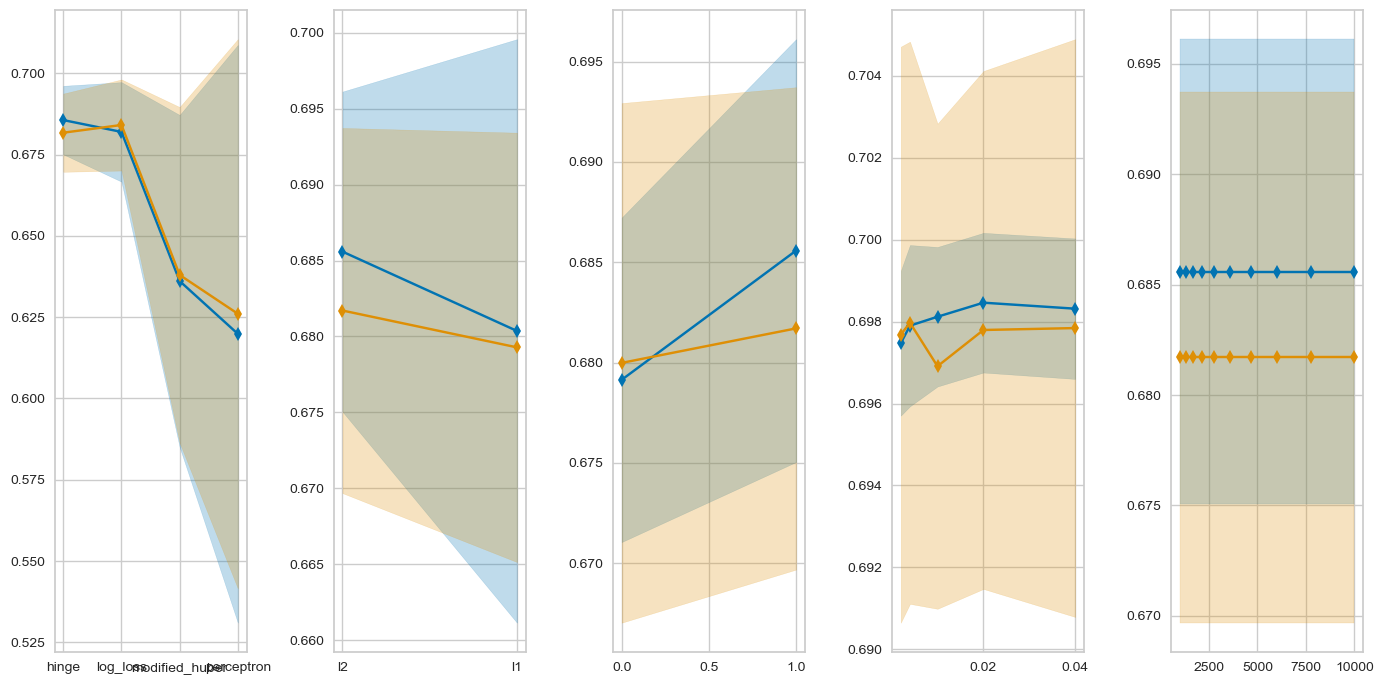

In [51]:
params = {
    "loss": ['hinge', 'log_loss', 'modified_huber', 'perceptron'],
    "penalty": ['l2', 'l1'],
    "fit_intercept": [True, False],
    "alpha": [0.002, 0.004, 0.01, 0.02, 0.04],
    "max_iter": [1000, 1292, 1668, 2154, 2782, 3593, 4641, 5995, 7742, 10000],
}

fig, axes = plt.subplots(1, len(params), figsize=(14, 7))

pos=0
for name, param_range in params.items():
    print(param_range)
    viz = ValidationCurve(
        clf_sgdc,
        param_name= name,
        param_range=param_range,
        cv=5,
        scoring="roc_auc",
        ax=axes[pos]
    )
    pos=pos+1
    viz.fit(X_train, y_train)
    # viz.show()
    
# Display the plot
plt.tight_layout()
plt.show()

In [55]:
params = {
    "loss": ['hinge', 'log_loss'],
    "penalty": ['l2'],
    "fit_intercept": [True],
    "alpha": [0.01, 0.02, 0.04],
    "max_iter": [1000, 2000],
}

grid_search = RandomizedSearchCV(
    clf_sgdc,
    scoring = 'roc_auc',
    param_distributions = params,
    random_state = SEED,
    cv=10,
    return_train_score=True,
)

grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=SGDClassifier(n_jobs=2, random_state=42),
                   param_distributions={'alpha': [0.01, 0.02, 0.04],
                                        'fit_intercept': [True],
                                        'loss': ['hinge', 'log_loss'],
                                        'max_iter': [1000, 2000],
                                        'penalty': ['l2']},
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [56]:
df_best_params = pd.DataFrame(grid_search.cv_results_)
cm = sns.diverging_palette(5, 250, as_cmap=True)
(
    pd.concat([
        df_best_params['params'].apply(pd.Series),
        df_best_params[['mean_train_score', 'mean_test_score', 'rank_test_score']]],
        axis = 1
    )
    .sort_values(by = 'rank_test_score')
    .style.background_gradient(cmap=cm, subset = ['mean_train_score', 'mean_test_score'])
)

,penalty,max_iter,loss,fit_intercept,alpha,mean_train_score,mean_test_score,rank_test_score
9,l2,2000,log_loss,True,0.020000,0.698520,0.697962,1
5,l2,1000,log_loss,True,0.010000,0.698357,0.697948,2
4,l2,2000,hinge,True,0.020000,0.698394,0.697915,3
8,l2,1000,hinge,True,0.020000,0.698394,0.697915,3
1,l2,2000,hinge,True,0.040000,0.698414,0.697902,5
3,l2,1000,hinge,True,0.040000,0.698414,0.697902,5
2,l2,1000,hinge,True,0.010000,0.698070,0.697832,7
6,l2,2000,hinge,True,0.010000,0.698070,0.697832,7
0,l2,1000,log_loss,True,0.040000,0.698302,0.697785,9
7,l2,2000,log_loss,True,0.040000,0.698302,0.697785,9


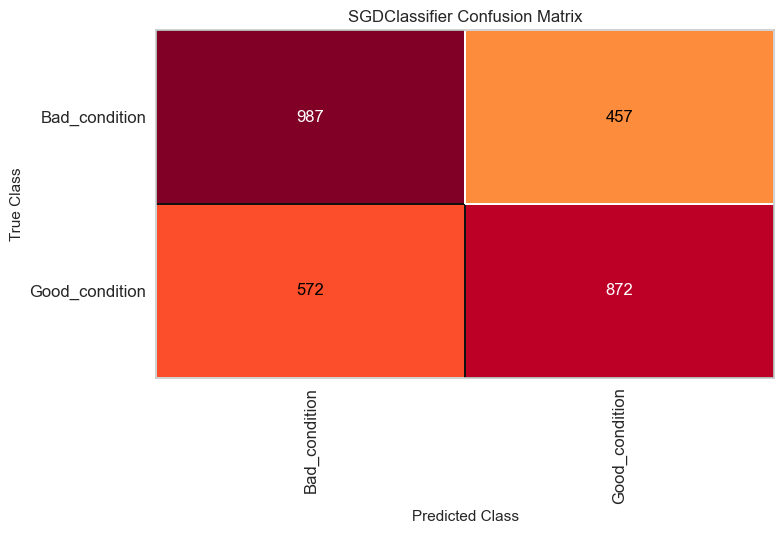

<Axes: title={'center': 'SGDClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [54]:
best_model_SGDC = grid_search.best_estimator_
clf_model = best_model_SGDC.fit( X_train, y_train )
predictions = clf_model.predict(X_test)


cm = ConfusionMatrix(
    best_model_SGDC,
    classes=['Bad_condition','Good_condition']
)
cm.fit(X_train, y_train)
cm.score(X_val, y_val)
cm.show()

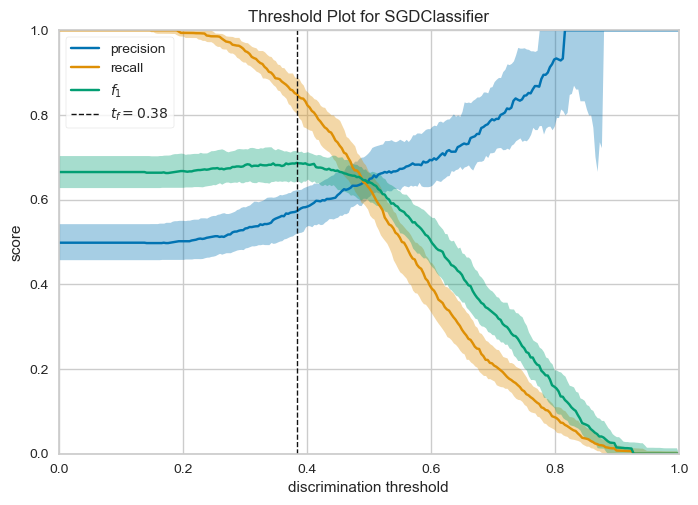

<Axes: title={'center': 'Threshold Plot for SGDClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [57]:
from yellowbrick.classifier.threshold import DiscriminationThreshold
# Especificamos la gráfica
visualizer = DiscriminationThreshold(
	best_model_SGDC,							# Pasar el estimador del mejor modelo que
    									# se obtiene de la validación cruzada.
	exclude = ["queue_rate"]			# Excluimos de la gráfica algunas métricas
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_val, y_val)
# Dibujamos la visualización.
visualizer.show()

## RFC

In [24]:
clf_rfc = RandomForestClassifier(random_state=SEED, n_jobs=-1)

[100, 120, 300]
[5, 8, 15, 25, 30]
[1, 2, 5, 10, 15, 50]
[1, 2, 5, 10]
['log2', 'sqrt', 'None']
['balanced', 'balanced_subsample']


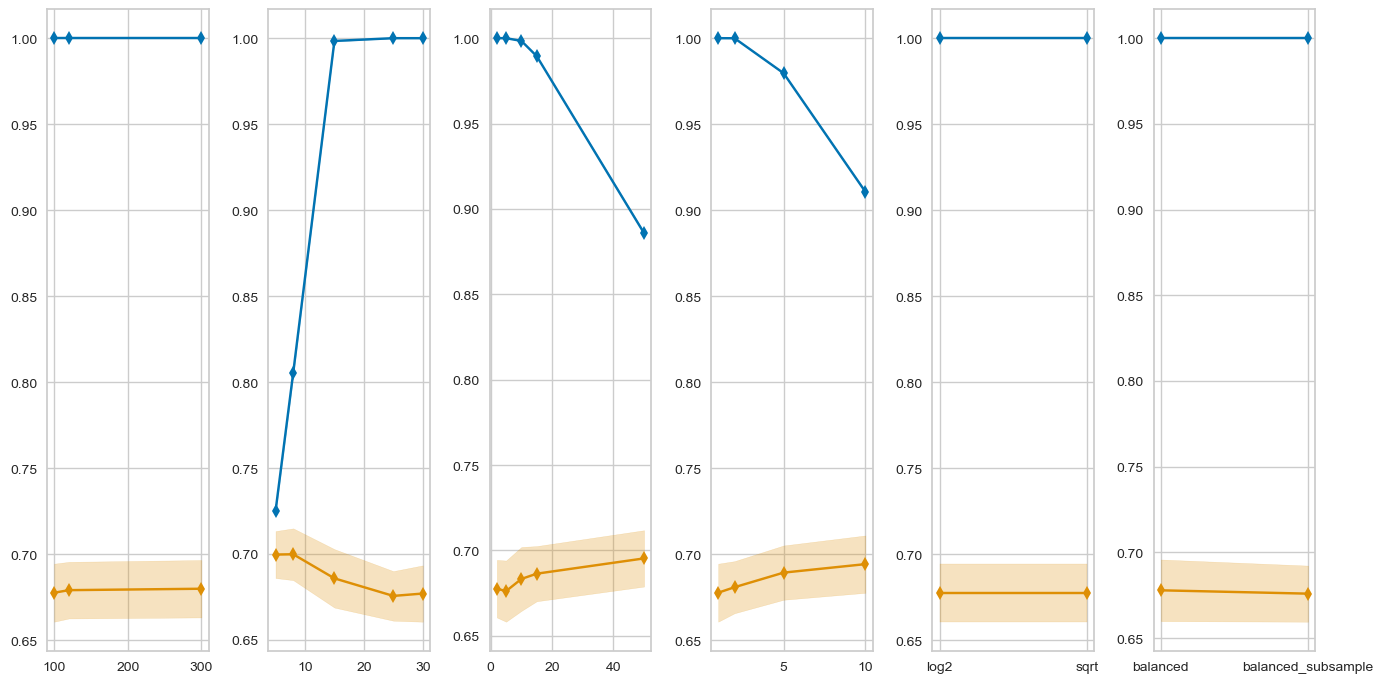

In [65]:
params = {
    "n_estimators": [100, 120, 300],
    "max_depth": [5, 8, 15, 25, 30],
    "min_samples_split": [1, 2, 5, 10, 15, 50],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ['log2', 'sqrt', 'None'],
    "class_weight": ['balanced', 'balanced_subsample'],
}

fig, axes = plt.subplots(1, len(params), figsize=(14, 7))

pos=0
for name, param_range in params.items():
    print(param_range)
    viz = ValidationCurve(
        clf_rfc,
        param_name= name,
        param_range=param_range,
        cv=10,
        scoring="roc_auc",
        ax=axes[pos]
    )
    pos=pos+1
    viz.fit(X_train, y_train)
    # viz.show()
    
# Display the plot
plt.tight_layout()
plt.show()

In [25]:
params = {
    'n_estimators': [*range(100,120,5)],
    'max_depth': [5, 8, 15],
    'min_samples_split':[*range(2,10,1)],
    'min_samples_leaf' : [2],
    'max_features' : ['log2', 'sqrt'],
    "class_weight": ['balanced', 'balanced_subsample']
}

grid_search = RandomizedSearchCV(
    clf_rfc,
    scoring = 'roc_auc',
    param_distributions = params,
    random_state = SEED,
    cv=10,
    return_train_score=True,
)

grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [5, 8, 15],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 105, 110, 115]},
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [26]:
df_best_params = pd.DataFrame(grid_search.cv_results_)
cm = sns.diverging_palette(5, 250, as_cmap=True)
(
    pd.concat([
        df_best_params['params'].apply(pd.Series),
        df_best_params[['mean_train_score', 'mean_test_score', 'rank_test_score']]],
        axis = 1
    )
    .sort_values(by = 'rank_test_score')
    .style.background_gradient(cmap=cm, subset = ['mean_train_score', 'mean_test_score'])
)


,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,class_weight,mean_train_score,mean_test_score,rank_test_score
1,110,8,2,sqrt,5,balanced_subsample,0.733975,0.700749,1
6,105,2,2,sqrt,5,balanced,0.734105,0.700742,2
9,110,5,2,sqrt,5,balanced_subsample,0.734072,0.700739,3
4,100,8,2,sqrt,5,balanced,0.733884,0.700700,4
0,100,5,2,log2,8,balanced_subsample,0.821084,0.699099,5
7,110,6,2,sqrt,8,balanced,0.819962,0.698776,6
2,115,2,2,sqrt,15,balanced_subsample,0.996255,0.686081,7
8,115,7,2,sqrt,15,balanced_subsample,0.989481,0.686069,8
5,100,7,2,sqrt,15,balanced_subsample,0.989139,0.685726,9
3,100,5,2,log2,15,balanced_subsample,0.994386,0.684210,10


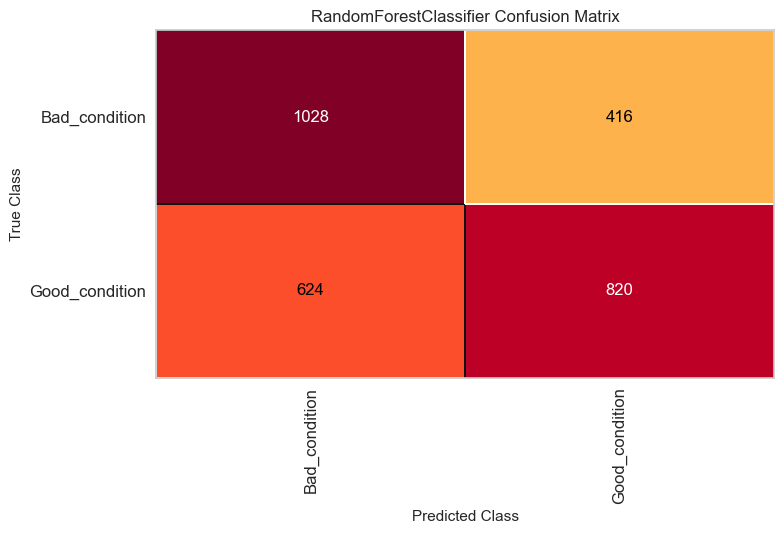

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [27]:
best_model_RFC = grid_search.best_estimator_
clf_model = best_model_RFC.fit( X_train, y_train )
predictions = clf_model.predict(X_test)


cm = ConfusionMatrix(
    best_model_RFC,
    classes=['Bad_condition','Good_condition']
)
cm.fit(X_train, y_train)
cm.score(X_val, y_val)
cm.show()

In [30]:
predictions = best_model_RFC.predict(X_test)

roc_auc_score(y_test, predictions)

0.6333102493074793

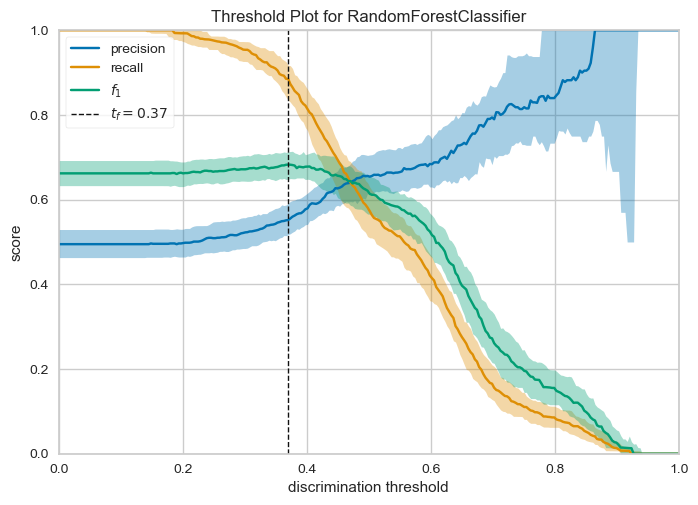

<Axes: title={'center': 'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [31]:
from yellowbrick.classifier.threshold import DiscriminationThreshold
# Especificamos la gráfica
visualizer = DiscriminationThreshold(
	best_model_RFC,							# Pasar el estimador del mejor modelo que
    									# se obtiene de la validación cruzada.
	exclude = ["queue_rate"]			# Excluimos de la gráfica algunas métricas
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_val, y_val)
# Dibujamos la visualización.
visualizer.show()

## XGBoost

In [4]:
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(random_state=SEED)

['gbtree', 'dart']
[0.3, 0.5, 0.7, 1]
[1, 2, 5, 10, 15, 50]
[5, 8, 15, 30, 50]
[1, 5, 10, 50, 100, 500]
[1, 0.5, 0.2, 0.1]
['uniform', 'subsample', 'gradient_based']


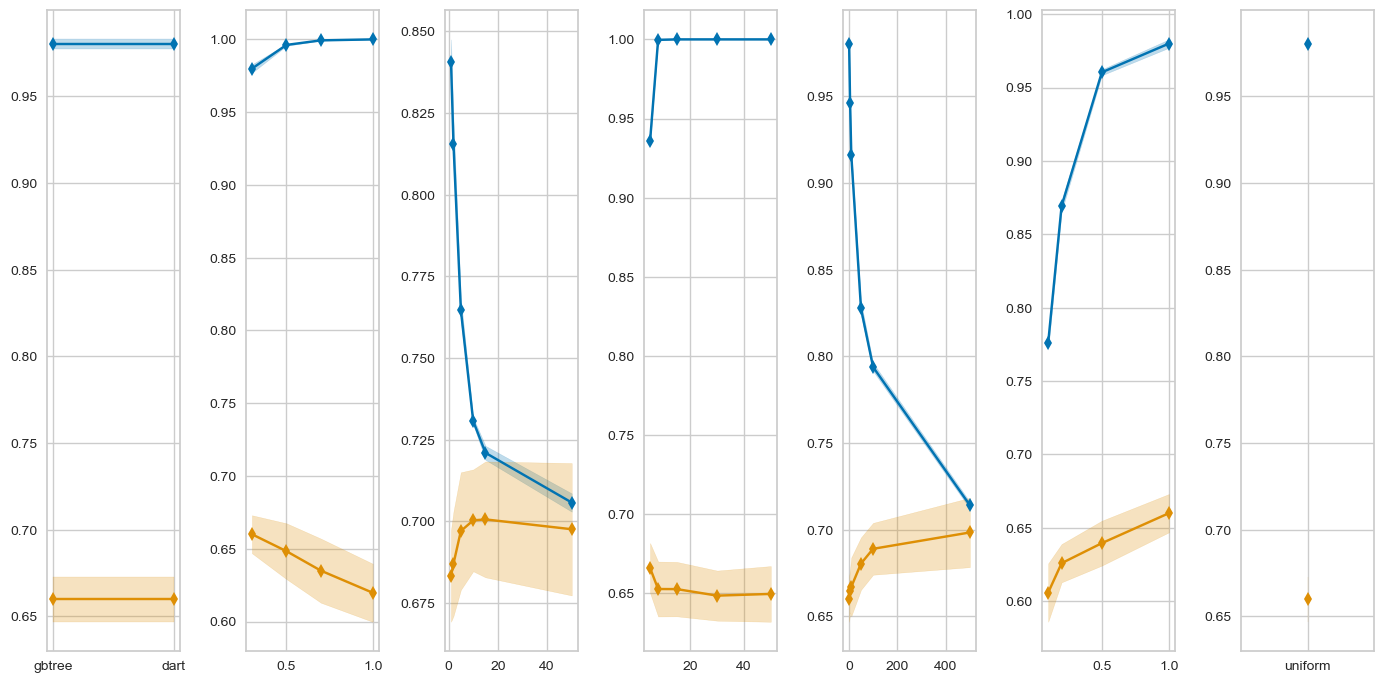

In [14]:
params = {
    "booster": ['gbtree', 'dart'],
    "eta": [0.3, 0.5, 0.7, 1],
    "gamma": [1, 2, 5, 10, 15, 50],
    "max_depth": [5, 8, 15, 30, 50],
    "min_child_weight": [1, 5, 10, 50, 100, 500],
    "subsample": [1, 0.7, 0.5],
    "sampling_method": ['uniform'],
}

fig, axes = plt.subplots(1, len(params), figsize=(14, 7))

pos=0
for name, param_range in params.items():
    print(param_range)
    viz = ValidationCurve(
        clf_xgb,
        param_name= name,
        param_range=param_range,
        cv=10,
        scoring="roc_auc",
        ax=axes[pos]
    )
    pos=pos+1
    viz.fit(X_train, y_train)
    # viz.show()
    
# Display the plot
plt.tight_layout()
plt.show()

In [9]:
params = {
    "booster": ['gbtree', 'dart'],
    "eta": [0.1, 0.2, 0.3, 0.5],
    "gamma": [1, 2, 5, 10, 15],
    "max_depth": [5, 8, 15],
    "min_child_weight": [1, 5, 10, 50, 100],
    "subsample": [1, 0.5, 0.2, 0.1],
    "sampling_method": ['uniform'],
}

rand_search = RandomizedSearchCV(
    clf_xgb,
    scoring = 'roc_auc',
    param_distributions = params,
    random_state = SEED,
    cv=10,
    return_train_score=True,
)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   param_distributions={'booster': ['gbtree', 'dart'],
                                        'eta': [0.1, 0.2, 0.3, 0.5],
                                        'gamma': [1, 2, 5, 10, 15],
                                        'max_depth': [5, 8, 15],
                                        'min_child_weight': [1, 5, 10, 50, 100],
                                        'sampling_method': ['uniform'],
                                        'subsample': [1, 0.5, 0.2, 0.1]},
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [15]:
df_best_params = pd.DataFrame(rand_search.cv_results_)
cm = sns.diverging_palette(5, 250, as_cmap=True)
(
    pd.concat([
        df_best_params['params'].apply(pd.Series),
        df_best_params[['mean_train_score', 'mean_test_score', 'rank_test_score']]],
        axis = 1
    )
    .sort_values(by = 'rank_test_score')
    .style.background_gradient(cmap=cm, subset = ['mean_train_score', 'mean_test_score'])
)

,subsample,sampling_method,min_child_weight,max_depth,gamma,eta,booster,mean_train_score,mean_test_score,rank_test_score
9,0.200000,uniform,1,15,15,0.100000,dart,0.709130,0.702224,1
1,0.200000,uniform,50,8,2,0.100000,dart,0.724676,0.700677,2
7,0.200000,uniform,100,8,1,0.100000,dart,0.710141,0.699898,3
0,1.000000,uniform,1,8,15,0.300000,gbtree,0.717747,0.699711,4
4,0.200000,uniform,100,5,5,0.200000,dart,0.709098,0.697943,5
2,0.200000,uniform,10,15,10,0.500000,gbtree,0.709598,0.687172,6
3,0.100000,uniform,50,5,10,0.500000,gbtree,0.697006,0.684867,7
6,0.200000,uniform,5,15,5,0.200000,gbtree,0.760835,0.675698,8
8,0.200000,uniform,10,8,1,0.200000,gbtree,0.801363,0.658244,9
5,0.500000,uniform,10,5,2,0.500000,dart,0.847901,0.646631,10


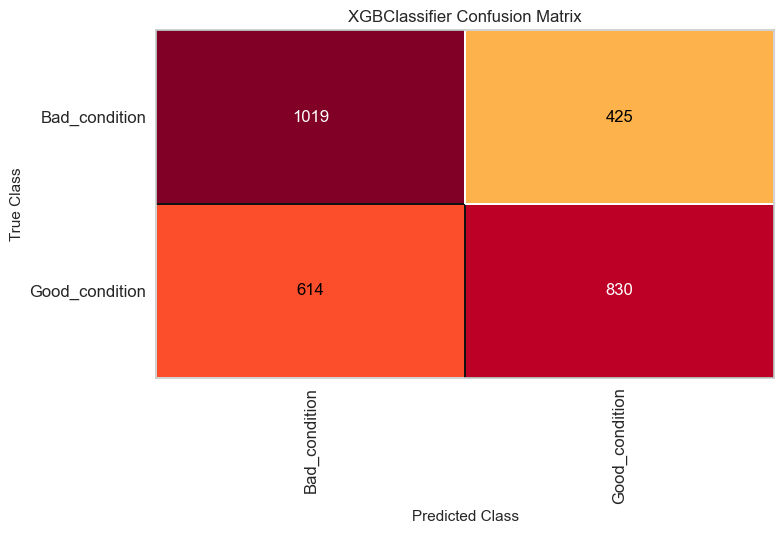

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [16]:
best_model_XGB = rand_search.best_estimator_
clf_model = best_model_XGB.fit( X_train, y_train )
predictions = clf_model.predict(X_test)


cm = ConfusionMatrix(
    best_model_XGB,
    classes=['Bad_condition','Good_condition']
)
cm.fit(X_train, y_train)
cm.score(X_val, y_val)
cm.show()

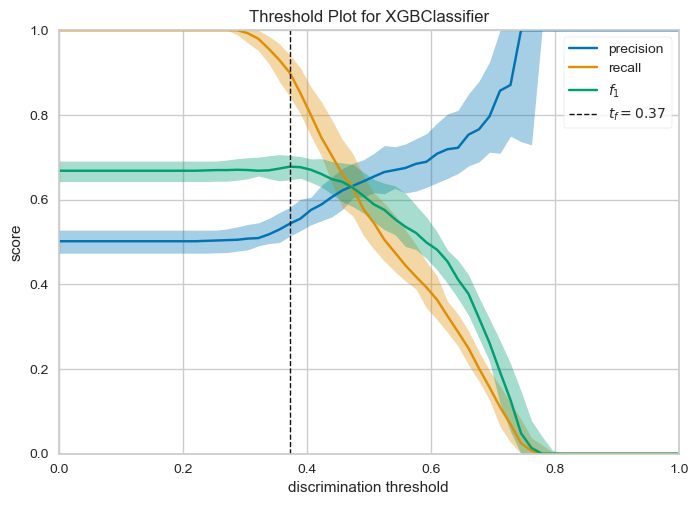

<Axes: title={'center': 'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [17]:
from yellowbrick.classifier.threshold import DiscriminationThreshold
# Especificamos la gráfica
visualizer = DiscriminationThreshold(
	best_model_XGB,							# Pasar el estimador del mejor modelo que
    									# se obtiene de la validación cruzada.
	exclude = ["queue_rate"]			# Excluimos de la gráfica algunas métricas
)
# Ajustamos la visualización a los datos de entrenamiento
visualizer.fit(X_val, y_val)
# Dibujamos la visualización.
visualizer.show()

In [ ]:
params = {
    "booster": ['gbtree'],
    "eta": [0.3, 0.5, 0.7, 1],
    "gamma": [1, 2, 5, 10, 15, 50],
    "max_depth": [5, 8, 15, 30, 50],
    "min_child_weight": [1, 5, 10, 50, 100, 500],
    "subsample": [1, 0.7, 0.5],
    "sampling_method": ['uniform'],
}

fig, axes = plt.subplots(1, len(params), figsize=(14, 7))

pos=0
for name, param_range in params.items():
    print(param_range)
    viz = ValidationCurve(
        clf_xgb,
        param_name= name,
        param_range=param_range,
        cv=10,
        scoring="roc_auc",
        ax=axes[pos]
    )
    pos=pos+1
    viz.fit(X_train, y_train)
    # viz.show()
    
# Display the plot
plt.tight_layout()
plt.show()